# Physics 390 - Climate Modelling

The first stage of modelling is to import relevant modules into the notebook. After this, data can be loaded in for each data file provided.


In [16]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt 

In [11]:
# Data directories
MODEL_DATA_DIR = "Model Data/"
SATELLITE_DATA_DIR = "Satellite Data/"

# Full model data file paths
cl_data_file = MODEL_DATA_DIR + 'clcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
clt_data_file = MODEL_DATA_DIR + 'cltcalipso_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_ice_data_file = MODEL_DATA_DIR + 'clcalipsoice_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'
cl_liq_data_file = MODEL_DATA_DIR + 'clcalipsoliq_CFmon_CESM2_amip_r2i1p1f1_gn_195001-201412.nc'

# Full satellite data file paths
cloud_fraction_phase_file = SATELLITE_DATA_DIR + '3D_CloudFraction_Phase330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
cloud_fraction_file = SATELLITE_DATA_DIR + '3D_CloudFraction330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
ECMWF_ta_plevels_file = SATELLITE_DATA_DIR + 'ECMWF_ta_plevels_2001_2018.nc'
map_low_high_mid_high_file = SATELLITE_DATA_DIR + 'MapLowMidHigh330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'

# Load model data into variables with readable access
cl_data = Dataset(cl_data_file, 'r')
clt_data = Dataset(clt_data_file, 'r')
cl_ice_data = Dataset(cl_ice_data_file, 'r')
cl_liq_data = Dataset(cl_liq_data_file, 'r')

# Load satellite data into variables with read access
cloud_fraction_phase_data = Dataset(cloud_fraction_phase_file, 'r')
cloud_fraction_data = Dataset(cloud_fraction_file, 'r')
ECMWF_ta_plevels_data = Dataset(ECMWF_ta_plevels_file, 'r')
map_low_high_mid_high_data = Dataset(map_low_high_mid_high_file, 'r')


In [17]:
# Declare some helper methods for easy viewing of data

# Display the names of all data points in the dataset and the number of data points in that set
def print_dataset_overview(dataset):
    print("Variables and Number of Data Points:")
    for key in dataset.variables.keys():
        print("\t", key, ": ", len(dataset.variables[key][:]), " data points")
    print("\n")

# Display the data for the variable name provided
def print_data_points(dataset, variable_name):
    print(variable_name, ":")
    print(dataset.variables[variable_name][:])
    print("\n")
    

In [51]:
## Declare some global variables
FIG_WIDTH = 10
FIG_HEIGHT = 5

### Clt Data Structure
From the helper methods above, and after analysing output data for the clt dataset, it appears that the clt data is organised in the following structure:

$cltcalipso[time][lat][lon]=$ fraction cloud cover at given $time$ at the coordinate $(lat, lon)$

In [12]:
print_dataset_overview(clt_data)
print_data_points(clt_data, "lon")
print_data_points(clt_data, "lat")
print_data_points(clt_data, "cltcalipso")

Variables and Number of Data Points:
C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
	 cltcalipso :  780  data points
	 lat :  192  data points
	 lon :  288  data points
	 time :  780  data points
	 time_bnds :  780  data points
	 lat_bnds :  192  data points
	 lon_bnds :  288  data points


lon :
[  0.     1.25   2.5    3.75   5.     6.25   7.5    8.75  10.    11.25
  12.5   13.75  15.    16.25  17.5   18.75  20.    21.25  22.5   23.75
  25.    26.25  27.5   28.75  30.    31.25  32.5   33.75  35.    36.25
  37.5   38.75  40.    41.25  42.5   43.75  45.    46.25  47.5   48.75
  50.    51.25  52.5   53.75  55.    56.25  57.5   58.75  60.    61.25
  62.5   63.75  65.    66.25  67.5   68.75  70.    71.25  72.5   73.75
  75.    76.25  77.5   78.75  80.    81.25  82.5   83.75  85.    86.25
  87.5   88.75  90.    91.25  92.5   93.75  95.    96.25  97.5   98.75
 100.

### First Test Plot: Initial Percentage Cloud Cover
The following plot is playing around with clt data. This is an attempt at plotting the fractional cloud cover at all a range of latitude coordinates, at the first time interval of the dataset.

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':


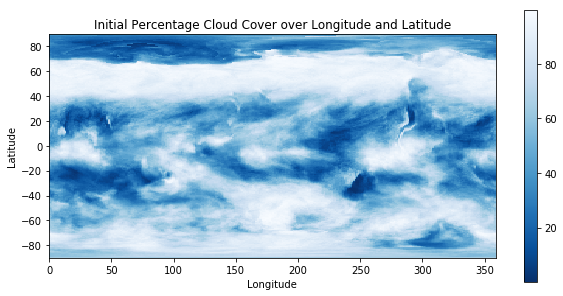

In [56]:
# Plot the percentage cloud cover over longitude and latitude at the first time interval
time_interval = 100

lon_max = max(clt_data.variables['lon'][:])
lon_min = min(clt_data.variables['lon'][:])
lat_max = max(clt_data.variables['lat'][:])
lat_min = min(clt_data.variables['lat'][:])

cloud_fraction_t_0 = clt_data.variables['cltcalipso'][time_interval]

# Since cloud cover is collected at linearly separated long, lat coords can approximate with this plot
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(cloud_fraction_t_0, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Initial Percentage Cloud Cover over Longitude and Latitude")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()

# Top of the Atmosphere Cloud Fraction 


## Seasonal Cloud Cover

In [157]:
# Need to come up with a way to extract only the information for times in the NZ summer (Dec - Feb)
from datetime import datetime  
from datetime import timedelta  

# Units of time: "days since 0001-01-01 00:00:00"
reference_datetime = datetime(year=1, month=1, day=1, hour=0, minute=0, second=0)

clt_time_data = clt_data.variables["time"][:]
clt_cloud_cover = clt_data.variables["cltcalipso"][:]

clt_cloud_cover_summer = []
clt_cloud_cover_winter = []

# Find a subset of cloud cover values for each season
for index in range(0, len(clt_time_data)):
    # Find the month corresponding to the current time
    time_delta = timedelta(days=clt_time_data[index])
    month = (reference_datetime + time_delta).month

    # Time period falls between December and February
    if (month == 12 or month == 1 or month == 2):
        clt_cloud_cover_summer.append(clt_cloud_cover[index])

    # Time period falls between June and August
    elif (month == 6 or month == 7 or month == 8):
        clt_cloud_cover_winter.append(clt_cloud_cover[index])

avg_cloud_cover_summer = np.mean(clt_cloud_cover_summer, axis=0)
avg_cloud_cover_winter = np.mean(clt_cloud_cover_winter, axis=0)

C:\Users\Maddie Beagley\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':


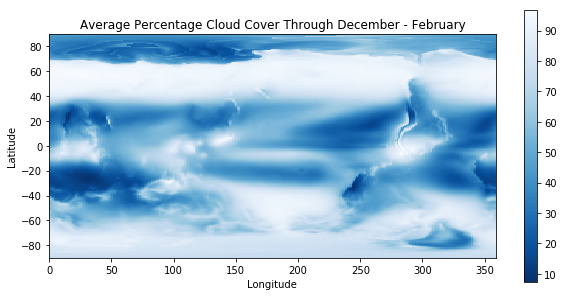

In [151]:
# Plot the average percentage of cloud cover through the winter months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_cloud_cover_summer, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Average Percentage Cloud Cover Through December - February")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()

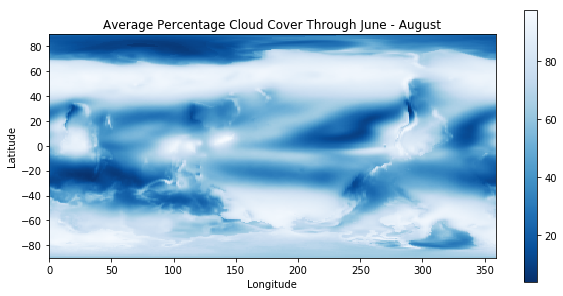

In [152]:
# Plot the average percentage of cloud cover through the summer months
plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
color_map = plt.imshow(avg_cloud_cover_winter, interpolation='nearest', 
                       extent=[lon_min, lon_max, lat_min, lat_max])

color_map.set_cmap("Blues_r")
plt.title("Average Percentage Cloud Cover Through June - August")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()